<a href="https://colab.research.google.com/github/MehrdadDastouri/anomaly_detection_autoencoder/blob/main/anomaly_detection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


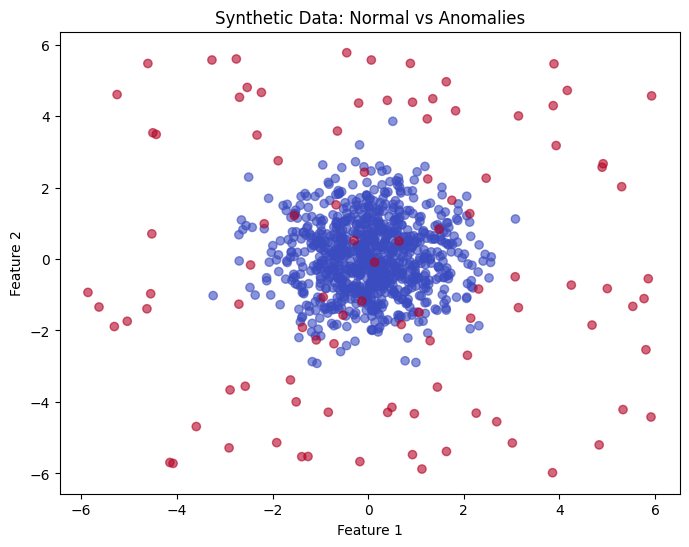

Epoch [1/50], Loss: 2.0443
Epoch [2/50], Loss: 1.5967
Epoch [3/50], Loss: 1.1540
Epoch [4/50], Loss: 1.0065
Epoch [5/50], Loss: 1.0075
Epoch [6/50], Loss: 0.9376
Epoch [7/50], Loss: 0.9104
Epoch [8/50], Loss: 0.8679
Epoch [9/50], Loss: 0.8680
Epoch [10/50], Loss: 0.8494
Epoch [11/50], Loss: 0.8502
Epoch [12/50], Loss: 0.8891
Epoch [13/50], Loss: 0.8637
Epoch [14/50], Loss: 0.8698
Epoch [15/50], Loss: 0.8277
Epoch [16/50], Loss: 0.8316
Epoch [17/50], Loss: 0.8565
Epoch [18/50], Loss: 0.8241
Epoch [19/50], Loss: 0.8427
Epoch [20/50], Loss: 0.8417
Epoch [21/50], Loss: 0.8281
Epoch [22/50], Loss: 0.8427
Epoch [23/50], Loss: 0.8470
Epoch [24/50], Loss: 0.8168
Epoch [25/50], Loss: 0.8461
Epoch [26/50], Loss: 0.8179
Epoch [27/50], Loss: 0.8204
Epoch [28/50], Loss: 0.8359
Epoch [29/50], Loss: 0.8197
Epoch [30/50], Loss: 0.8151
Epoch [31/50], Loss: 0.8762
Epoch [32/50], Loss: 0.8111
Epoch [33/50], Loss: 0.9102
Epoch [34/50], Loss: 0.8134
Epoch [35/50], Loss: 0.8158
Epoch [36/50], Loss: 0.8141
E

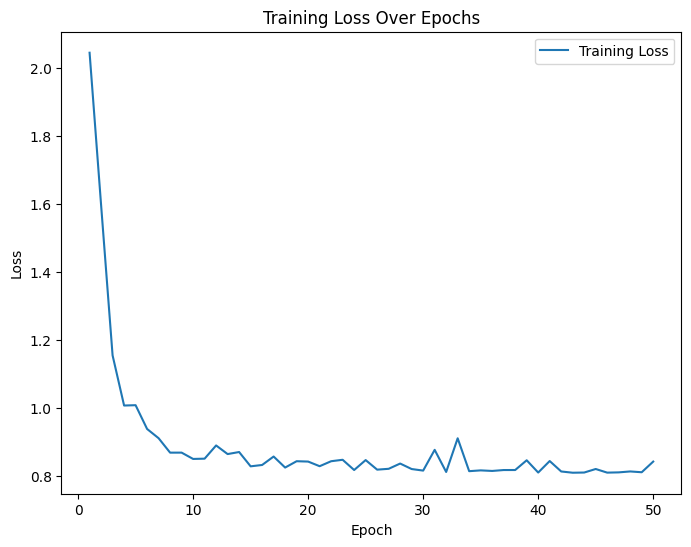

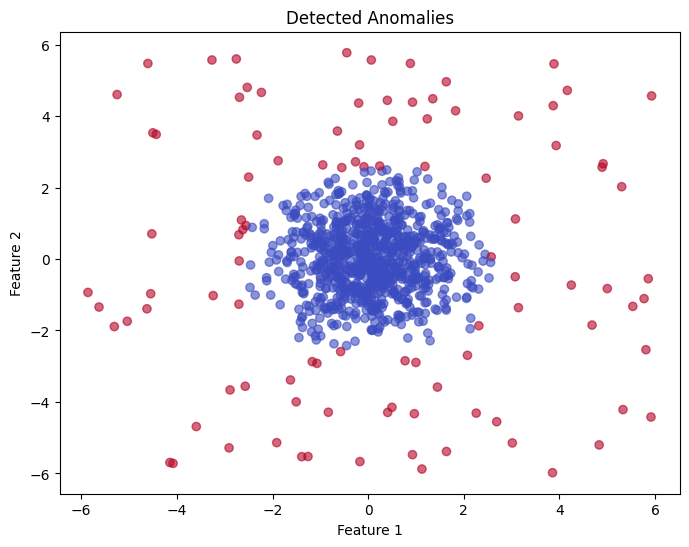

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       900
     Anomaly       0.77      0.77      0.77       100

    accuracy                           0.95      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.95      0.95      0.95      1000



In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate synthetic data (normal and anomalies)
def generate_data(num_samples=1000, anomaly_ratio=0.1):
    normal_data = np.random.normal(loc=0.0, scale=1.0, size=(int(num_samples * (1 - anomaly_ratio)), 2))
    anomaly_data = np.random.uniform(low=-6, high=6, size=(int(num_samples * anomaly_ratio), 2))
    data = np.concatenate([normal_data, anomaly_data], axis=0)
    labels = np.concatenate([np.zeros(len(normal_data)), np.ones(len(anomaly_data))], axis=0)  # 0: normal, 1: anomaly
    return data, labels

data, labels = generate_data()
data = torch.tensor(data, dtype=torch.float32).to(device)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], c=labels, cmap="coolwarm", alpha=0.6)
plt.title("Synthetic Data: Normal vs Anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
input_size = 2
hidden_size = 2
model = Autoencoder(input_size, hidden_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the Autoencoder
epochs = 50
batch_size = 32
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for batch in data_loader:
        # Forward pass
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss / len(data_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Evaluate the Autoencoder
with torch.no_grad():
    reconstructed_data = model(data)

# Compute reconstruction error
reconstruction_error = torch.mean((data - reconstructed_data) ** 2, dim=1).cpu().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)  # Top 10% as anomalies

# Detect anomalies
predicted_labels = (reconstruction_error > threshold).astype(int)

# Visualize the anomalies
plt.figure(figsize=(8, 6))
plt.scatter(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], c=predicted_labels, cmap="coolwarm", alpha=0.6)
plt.title("Detected Anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Evaluate the detection
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(labels, predicted_labels, target_names=["Normal", "Anomaly"]))